# Multi-Objective Flow Direction Algorithm (MOFDA) for Task Offloading

This notebook implements the MOFDA algorithm for the task offloading problem based on the paper "Leader selection based Multi-Objective Flow Direction Algorithm. (MOFDA): A novel approach for engineering design problems."

In [1]:
# !uv pip install pymoo

In [74]:
import sys
import os
from pathlib import Path
import copy

# Add the project root to the Python path
sys.path.append('../')

import numpy as np
from pymoo.core.algorithm import Algorithm
from pymoo.core.population import Population
# For newer pymoo versions use:
try:
    from pymoo.util.archive import Archive
except ImportError:
    # Fallback for older pymoo versions
    try:
        from pymoo.core.archive import Archive
    except ImportError:
        # Create a simple Archive class if not available
        class Archive(Population):
            def __init__(self, *args, **kwargs):
                super().__init__(*args, **kwargs)

from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from pymoo.util.misc import find_duplicates
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.core.individual import Individual
from src.task_offloading_moo.pymoo.problem import TaskOffloadingProblem
from src.task_offloading_moo.pymoo.operators.repair import TaskOffloadingRepair
from src.task_offloading_moo.pymoo.operators.sampling import TaskOffloadingSampling

## 1. Implementing MOFDA

First, we'll implement the Multi-Objective Flow Direction Algorithm based on the paper description.

In [75]:
class MOFDAArchive:
    """Custom archive implementation for MOFDA algorithm."""
    
    def __init__(self, size=None):
        self.size = size
        self.data = Population()
        self.grid = None
    
    def __len__(self):
        return len(self.data)

    def add(self, pop):
        """Add solutions to the archive and return the archive itself.
        This method is needed for compatibility with pymoo's algorithm framework."""
        self.update(pop)
        return self

    def get(self, key):
        return self.data.get(key) if len(self.data) > 0 else None
    
    def _accept(self, pop):
        """Accept only non-dominated solutions to the archive"""
        # Safety check for empty populations
        if pop is None or len(pop) == 0:
            return np.array([], dtype=bool)
            
        # Get the population's objective values
        F_pop = pop.get("F")
        
        # If archive is empty, just do non-dominated sorting within the population
        if len(self.data) == 0:
            if len(pop) <= 1:
                return np.full(len(pop), True)
            else:
                # Find non-dominated solutions in the population
                fronts = NonDominatedSorting().do(F_pop, only_non_dominated_front=True)
                # Create acceptance mask
                accepted = np.zeros(len(pop), dtype=bool)
                
                # Handle both single integer and array cases
                if isinstance(fronts[0], (int, np.integer)):
                    accepted[fronts[0]] = True
                else:
                    for idx in fronts[0]:
                        accepted[idx] = True
                return accepted
        
        # If we have archive data, compare with current population
        F_archive = self.data.get("F")
        
        # Combine archive and population objectives for sorting
        F_all = np.vstack([F_archive, F_pop])
        
        # Find non-dominated solutions across both sets
        fronts = NonDominatedSorting().do(F_all, only_non_dominated_front=True)
        
        # Create acceptance mask for population solutions
        accepted = np.zeros(len(pop), dtype=bool)
        archive_size = len(F_archive)
        
        # Handle both single integer and array cases
        if isinstance(fronts[0], (int, np.integer)):
            if fronts[0] >= archive_size:
                accepted[fronts[0] - archive_size] = True
        else:
            for idx in fronts[0]:
                if idx >= archive_size:
                    accepted[idx - archive_size] = True
        
        return accepted
    
    def update(self, pop):
        if pop is None or len(pop) == 0:
            return
            
        accept = self._accept(pop)
        if np.any(accept):
            accepted = pop[accept]
            if len(self.data) == 0:
                self.data = accepted
            else:
                self.data = Population.merge(self.data, accepted)
            self._filter()
    
    def _filter(self):
        if self.size is None or len(self.data) <= self.size:
            return
        
        # Use grid-based crowding distance
        F = self.data.get("F")
        n_dim = F.shape[1]
        n_grid = max(2, int(np.ceil(self.size ** (1/n_dim))))
        
        grid_indices = np.zeros((len(F), n_dim), dtype=int)
        for i in range(n_dim):
            f_min, f_max = F[:, i].min(), F[:, i].max()
            delta = (f_max - f_min) / n_grid if f_max > f_min else 1.0
            grid_indices[:, i] = np.minimum(np.floor((F[:, i] - f_min) / delta), n_grid-1)
        
        # Count solutions in each cell
        unique_cells, cell_counts = np.unique(grid_indices, axis=0, return_counts=True)
        crowding = np.zeros(len(F))
        for i, indices in enumerate(grid_indices):
            idx = np.where((unique_cells == indices).all(axis=1))[0][0]
            crowding[i] = cell_counts[idx]
        
        # Keep the least crowded solutions
        I = np.argsort(crowding)[:self.size]
        self.data = self.data[I]
        
        # Update grid information
        self.grid = {'indices': grid_indices[I], 'counts': crowding[I]}
    
    def get_leader(self):
        if len(self.data) == 0:
            return None
        
        if self.grid is None:
            return self.data[np.random.randint(len(self.data))]
        
        # Select from less crowded regions
        probs = 1.0 / self.grid['counts']
        probs = probs / np.sum(probs)
        idx = np.random.choice(len(self.data), p=probs)
        return self.data[idx]

In [76]:
from pymoo.util.display.multi import MultiObjectiveOutput

class MOFDAOptimizer(Algorithm):
    """Multi-Objective Flow Direction Algorithm (MOFDA) for multi-objective optimization."""
    
    def __init__(self,
                 pop_size=100,
                 sampling=None,
                 repair=None,
                 archive_size=100,
                 n_max_iters=100,
                 w=0.4,        # weight factor for velocity control
                 c1=2,         # control parameter for neighborhood radius
                 c2=2,         # control parameter for flow movement
                 beta=4,       # number of neighbors around each flow
                 delta=0.5,    # mutation rate
                 use_soft_repair=True,
                 save_history=False,
                 **kwargs):
        
        super().__init__(output=MultiObjectiveOutput(), **kwargs)
        
        self.pop_size = pop_size
        self.sampling = sampling
        self.repair = repair
        self.n_max_iters = n_max_iters
        self.archive_size = archive_size
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.beta = beta
        self.delta = delta
        self.use_soft_repair = use_soft_repair
        self.save_history = save_history
        
        # Create archive without parameters first
        self.archive = MOFDAArchive(size=archive_size)
        # Then set size attribute separately
        self.archive.size = archive_size
        self.current_iter = 0

    def copy(self, deep=False):
        return copy.deepcopy(self) if deep else copy.copy(self)

    def _initialize_infill(self):
        """Initialize the first population if it doesn't exist yet."""
        # Create initial population using the sampling method
        if self.sampling is not None:
            self.pop = self.sampling.do(self.problem, self.pop_size)
        else:
            # Use default random sampling as fallback
            X = np.random.random((self.pop_size, self.problem.n_var))
            # Scale to problem bounds
            xl, xu = self.problem.xl, self.problem.xu
            X = xl + X * (xu - xl)
            # Create population
            self.pop = Population.new("X", X)
        
        # Evaluate the initial population
        self.evaluator.eval(self.problem, self.pop)
        
        return self.pop

    def _initialize_advance(self, infills=None, **kwargs):
        # Add initial population to archive
        self.archive.update(self.pop)

    def _repair_solution(self, X):
        """Ensure solutions contain valid integer machine assignments."""
        if X is None:
            return X
            
        # Make a copy to avoid modifying the original
        X_repaired = X.copy()
        
        # Get problem bounds
        xl = self.problem.xl
        xu = self.problem.xu
        
        # Apply bounds and convert to integers
        for i in range(len(X_repaired)):
            # First round to nearest integers
            X_repaired[i] = np.round(X_repaired[i])
            
            # Then ensure values are within bounds
            X_repaired[i] = np.maximum(X_repaired[i], xl)
            X_repaired[i] = np.minimum(X_repaired[i], xu)
            
            # Convert to integers explicitly
            X_repaired[i] = X_repaired[i].astype(int)
        
        return X_repaired

    def _infill(self):
        # Create offspring using FDA operators
        n_offsprings = self.pop_size
        offsprings = np.empty(n_offsprings, dtype=object)
        
        # Get current population
        X = self.pop.get("X")
        n_vars = X.shape[1]
        
        # Get leader from archive (best non-dominated solution)
        leader = self.archive.get_leader()
        leader_X = leader.get("X") if leader is not None else None
        
        # For each individual in population
        for i in range(n_offsprings):
            # Current flow position
            flow_X = X[i % len(X)].copy()
            
            # Generate neighbors for each flow
            neighbors_X = np.empty((self.beta, n_vars))
            for j in range(self.beta):
                # Create neighbor using normal distribution around current flow
                delta = np.random.randn(n_vars)
                
                # Calculate neighborhood radius
                radius = delta * np.linalg.norm(leader_X - flow_X) if leader_X is not None else delta
                
                # Create neighbor
                neighbors_X[j] = flow_X + radius
            
            # Evaluate neighbors
                        # Fixed code using proper Population
                        # In the _infill method of MOFDAOptimizer:
            
            # Before evaluation, make sure all machine assignments are proper integers
            for j in range(len(neighbors_X)):
                # Important: First convert to integer type
                neighbors_X[j] = neighbors_X[j].astype(int)
                
                # Then use the problem's repair mechanism which knows about constraints
                if self.use_soft_repair and hasattr(self.problem, 'soft_repair'):
                    neighbors_X[j] = self.problem.soft_repair(flow_X, neighbors_X[j])
                elif hasattr(self.problem, 'repair'):
                    neighbors_X[j] = self.problem.repair(neighbors_X[j])
                else:
                    # Basic bounds repair as fallback
                    xl, xu = self.problem.xl, self.problem.xu
                    neighbors_X[j] = np.clip(neighbors_X[j], xl, xu).astype(int)
                        # Inside your _infill method, after generating neighbors_X:
            num_machines = self.problem.dataset_generator.get_num_machines()
            for j in range(len(neighbors_X)):
                # Round the solution and cast to integer
                repaired = np.round(neighbors_X[j]).astype(int)
                # Clip values to the valid range
                repaired = np.clip(repaired, 0, num_machines - 1)
                # (Optionally, apply your domain-specific repair if available)
                if self.use_soft_repair and hasattr(self.problem, 'soft_repair'):
                    repaired = self.problem.soft_repair(flow_X, repaired)
                neighbors_X[j] = repaired
            neighbors_X = neighbors_X.astype(int)
            # Create population with repaired solutions
            neighbors = Population.new("X", neighbors_X)
            
            self.evaluator.eval(self.problem, neighbors)
            
            # Find best neighbor (using non-dominated sorting if multi-objective)
            F_neighbors = np.array([n.get("F") for n in neighbors])
            F_current = self.pop[i].get("F")
            
            # Check if any neighbor dominates current flow
            dominated = False
            best_neighbor_idx = 0
            
            for j in range(self.beta):
                if self._dominates(F_neighbors[j], F_current):
                    dominated = True
                    best_neighbor_idx = j
                    break
            
            # Update flow position
            if dominated:
                # Calculate flow velocity based on slope
                slope = (flow_X - neighbors_X[best_neighbor_idx]) / np.linalg.norm(flow_X - neighbors_X[best_neighbor_idx])
                velocity = np.random.random() * slope
                
                # Update flow position
                new_X = flow_X + velocity
            else:
                # Sink filling process - randomly select another flow
                random_idx = np.random.randint(self.pop_size)
                
                if random_idx == i:
                    random_idx = (random_idx + 1) % self.pop_size
                
                random_flow = self.pop[random_idx]
                
                # Compare fitness
                if self._dominates(random_flow.get("F"), F_current):
                    # Move towards the random flow
                    new_X = flow_X + np.random.random() * (random_flow.get("X") - flow_X)
                elif leader_X is not None:
                    # Move towards the leader
                    new_X = flow_X + 2 * np.random.random() * (leader_X - flow_X)
                else:
                    # Apply mutation
                    if np.random.random() < self.delta:
                        new_X = flow_X + np.random.randn(n_vars) * 0.1
                    else:
                        new_X = flow_X
            
            # Create new individual
            offsprings[i] = Individual(X=new_X)
        
        # Apply repair operator if necessary
        if self.repair is not None:
            offsprings = self.repair.do(self.problem, Population(offsprings), use_soft=self.use_soft_repair)
        
        return offsprings
    
    def _dominates(self, F1, F2):
        """Check if F1 dominates F2 (assuming minimization)."""
        return np.all(F1 <= F2) and np.any(F1 < F2)

    def _advance(self, infills=None, **kwargs):
        # Update archive with evaluated offspring
        self.archive.update(infills)
        
        # Select next population from combined previous population and offspring
        self.pop = self._select(self.pop, infills)
        
        # Save algorithm state in history
        if self.save_history and self.current_iter % 1 == 0:
            self.history.append(self.copy(deep=True))
            
        self.current_iter += 1

    def _select(self, pop, off):
        # Combine parent and offspring population
        merged = Population.merge(pop, off)
        
        # For selection, use non-dominated sorting
        F = merged.get("F")
        
        # Perform non-dominated sorting
        fronts = NonDominatedSorting().do(F, n_stop_if_ranked=len(merged))
        
        # Prepare indices to be selected
        n_remaining = self.pop_size
        indices = []
        
        for front in fronts:
            # If we can take the whole front, add it
            if len(front) <= n_remaining:
                indices.extend(front)
                n_remaining -= len(front)
            # Otherwise, select based on crowding distance
            else:
                # Calculate crowding distance for this front
                crowding_of_front = self._calc_crowding_distance(F[front])
                
                # Sort by crowding distance (higher is better)
                I = np.argsort(-crowding_of_front)
                I = I[:n_remaining]
                
                # Add selected individuals from this front
                indices.extend(front[I])
                break
                
        # Create the population for next generation
        return merged[indices]
    
    def _calc_crowding_distance(self, F):
        n_points, n_obj = F.shape
        
        if n_points <= 2:
            return np.full(n_points, np.inf)
        
        # Initialize crowding distance
        crowding = np.zeros(n_points)
        
        # Calculate crowding distance for each objective
        for i in range(n_obj):
            # Sort by current objective
            idx = np.argsort(F[:, i])
            
            # Set the boundary points to infinity
            crowding[idx[0]] = np.inf
            crowding[idx[-1]] = np.inf
            
            # Calculate crowding distance for the rest
            f_min = F[idx[0], i]
            f_max = F[idx[-1], i]
            
            if f_max > f_min:
                # Add normalized distance to crowding
                crowding[idx[1:-1]] += (F[idx[2:], i] - F[idx[:-2], i]) / (f_max - f_min)
                
        return crowding
        
    def _set_optimum(self, **kwargs):
        """Fix the optimum population to ensure it has valid X values"""
        # Create a proper Population if needed
        if len(self.archive.data) == 0:
            # Handle empty archive case by using best from current population
            self.opt = Population()
            return
            
        # Create Population from archive data
        self.opt = Population.create(self.archive.data)
        
        # Ensure X values are present and properly formatted
        if self.opt.get("X") is None or self.opt.get("X").size == 0:
            # Copy X values from the current population if missing
            if len(self.pop) > 0 and self.pop.get("X") is not None:
                n_vars = self.pop.get("X").shape[1]
                self.opt.set("X", np.zeros((len(self.opt), n_vars)))

## 2. Problem Setup

Now let's set up the task offloading problem similar to the PUMA notebook.

In [77]:
pop_size = 100
n_max_iters = 10

num_cloud_machines = 30
num_fog_machines = 20
num_tasks = 500

# Add this code above your algorithm definition
from pymoo.core.termination import Termination

class MOFDATermination(Termination):
    def __init__(self, n_max_gen=100):
        super().__init__()
        self.n_max_gen = n_max_gen
        
    def _update(self, algorithm):
        # Calculate progress as percentage of maximum generations
        if algorithm.n_gen >= self.n_max_gen:
            return 1.0
        else:
            return algorithm.n_gen / self.n_max_gen

algorithm = MOFDAOptimizer(
    repair=TaskOffloadingRepair(),
    use_soft_repair=True,
    pop_size=pop_size,
    sampling=TaskOffloadingSampling(),
    n_max_iters=n_max_iters,
    archive_size=100,
    save_history=True,
    w=0.4,
    c1=2,
    c2=2,
    beta=4,
    delta=0.5
)

problem = TaskOffloadingProblem(num_cloud_machines, num_fog_machines, num_tasks)

## 3. Run Optimization

In [78]:
res = minimize(problem,
               algorithm,
               termination=MOFDATermination(n_max_gen=n_max_iters),
               seed=1,
               verbose=True)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      1 |             - |             -
     2 |      600 |      1 |  0.000000E+00 |             f
     3 |     1100 |      1 |  0.000000E+00 |             f
     4 |     1600 |      1 |  0.000000E+00 |             f
     5 |     2100 |      1 |  0.000000E+00 |             f
     6 |     2600 |      1 |  0.000000E+00 |             f


KeyboardInterrupt: 

## 4. Visualize Results

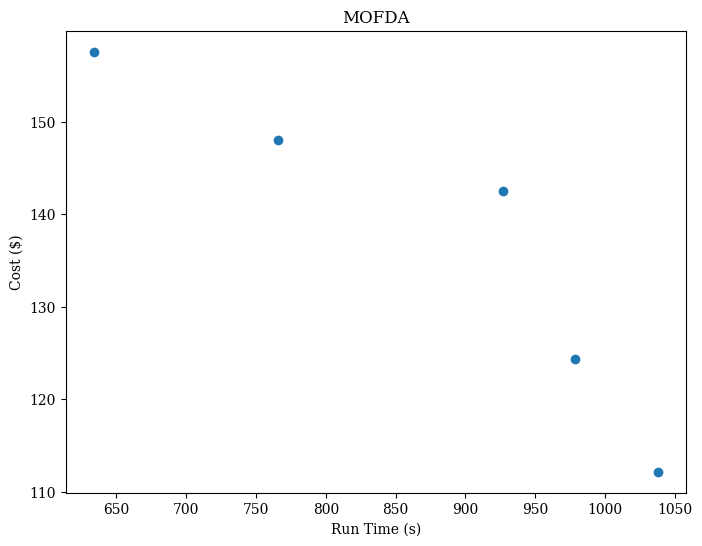

In [58]:
plot = Scatter(title="MOFDA")
plot.add(res.F)
plot.axis_labels = problem.dataset_generator.get_objective_names()
_ = plot.show()

## 5. Create Animation of Optimization Progress

In [59]:
!pip install pyrecorder


[notice] A new release of pip available: 22.2.1 -> 25.0.1
[notice] To update, run: C:\Users\robin\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip


In [60]:
from pyrecorder.recorder import Recorder
from pyrecorder.writers.video import Video
import os

out_path = os.path.join(os.path.dirname(os.getcwd()), "output")
os.makedirs(out_path, exist_ok=True)
with Recorder(Video(os.path.join(out_path, "mofda_video.mp4"))) as rec:

    # for each algorithm object in the history
    for entry in res.history:
        sc = Scatter(title=("Gen %s" % entry.n_gen))
        sc.add(entry.opt.get("F"))
        sc.add(entry.problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
        sc.do()

        # record the current visualization to the video
        rec.record()